In [119]:
import pandas as pd
import numpy as np
import xgboost as xgb
import dalex as dx

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer

import xgboost as xgb
import numpy as np
from typing import Tuple
from sklearn.metrics import balanced_accuracy_score, accuracy_score

import sympy as sp

In [120]:
titanic = dx.datasets.load_titanic()
X = titanic.drop(columns='survived')
y = titanic.survived

In [121]:
X_transformed = pd.get_dummies(X, drop_first=True)
display(X.head())
display(X_transformed.head())

,gender,age,class,embarked,fare,sibsp,parch
0,male,42.0,3rd,Southampton,7.11,0,0
1,male,13.0,3rd,Southampton,20.05,0,2
2,male,16.0,3rd,Southampton,20.05,1,1
3,female,39.0,3rd,Southampton,20.05,1,1
4,female,16.0,3rd,Southampton,7.13,0,0


,age,fare,sibsp,parch,gender_male,class_2nd,class_3rd,class_deck crew,class_engineering crew,class_restaurant staff,class_victualling crew,embarked_Cherbourg,embarked_Queenstown,embarked_Southampton
0,42.0,7.11,0,0,True,False,True,False,False,False,False,False,False,True
1,13.0,20.05,0,2,True,False,True,False,False,False,False,False,False,True
2,16.0,20.05,1,1,True,False,True,False,False,False,False,False,False,True
3,39.0,20.05,1,1,False,False,True,False,False,False,False,False,False,True
4,16.0,7.13,0,0,False,False,True,False,False,False,False,False,False,True


In [122]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [123]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [124]:
y, y_hut = sp.symbols('y y_hut')
lambda_reg = sp.symbols('lambda_reg')
f = sp.Function('f')(y, y_hut, lambda_reg)

f = (y_hut-y)**2 + lambda_reg*(y_hut**2)

grad = sp.lambdify((y, y_hut, lambda_reg), f.diff(y_hut), 'numpy')
hess = sp.lambdify((y, y_hut, lambda_reg), f.diff(y_hut, y_hut), 'numpy')

y_pred = dtrain.get_label()
y_rel = dtrain.get_label()

lambda_r = 0.1
grad, hess = grad(y=y_rel, y_hut=y_pred, lambda_reg=lambda_r), hess(y=y_rel, y_hut=y_pred, lambda_reg=lambda_r)

if type(grad) == float:
    grad = np.ones(y_pred.shape[0]) * grad

if type(hess) == float:
    hess = np.ones(y_pred.shape[0]) * hess


In [125]:
# Backup

def XGBoost_changed(lambda_r: float, dtrain: xgb.DMatrix) -> xgb.Booster:
    def objective_function(y_pred: np.ndarray, dtrain_: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
        y, y_hut = sp.symbols('y y_hut', real=True)
        lambda_reg = sp.symbols('lambda_reg')
        f = sp.Function('f')(y, y_hut, lambda_reg)

        f = (y_hut-y)**2 + lambda_reg*y_hut

        grad = sp.lambdify((y, y_hut, lambda_reg), f.diff(y_hut), 'numpy')
        hess = sp.lambdify((y, y_hut, lambda_reg), f.diff(y_hut, y_hut), 'numpy')

        y_rel = dtrain_.get_label()

        grad, hess = grad(y=y_rel, y_hut=y_pred, lambda_reg=lambda_r), hess(y=y_rel, y_hut=y_pred, lambda_reg=lambda_r)

        if type(grad) in [float, int]:
            grad = np.ones(y_pred.shape[0]) * grad
        if type(hess) in [float, int]:
            hess = np.ones(y_pred.shape[0]) * hess
        
        return grad, hess
    
    params = {
        # 'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'seed': 2001,
    }

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=8,
        obj=objective_function,
        evals=[(dtrain, 'train')]
    )
    return model

In [126]:
# Test
list = []
def XGBoost_changed(lambda_r: float, dtrain: xgb.DMatrix) -> xgb.Booster:
    def objective_function(y_pred: np.ndarray, dtrain_: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
        w = np.matmul(y_pred, np.linalg.pinv(dtrain.get_data().toarray()).T)
        print(sum(w))
        y, y_hut = sp.symbols('y y_hut', real=True)
        lambda_reg = sp.symbols('lambda_reg')
        f = sp.Function('f')(y, y_hut, lambda_reg)

        f = (y_hut-y)**2 + lambda_reg * np.sum(w**2)

        grad = sp.lambdify((y, y_hut, lambda_reg), f.diff(y_hut), 'numpy')
        hess = sp.lambdify((y, y_hut, lambda_reg), f.diff(y_hut, y_hut), 'numpy')

        y_rel = dtrain_.get_label()
        
        list.append(w)

        grad, hess = grad(y=y_rel, y_hut=y_pred, lambda_reg=lambda_r), hess(y=y_rel, y_hut=y_pred, lambda_reg=lambda_r)

        if type(grad) in [float, int]:
            grad = np.ones(y_pred.shape[0]) * grad
        if type(hess) in [float, int]:
            hess = np.ones(y_pred.shape[0]) * hess
        
        return grad, hess
    
    params = {
        # 'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'seed': 2001,
    }

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=8,
        obj=objective_function,
        # evals=[(dtrain, 'train')]
    )
    return model

In [127]:
arr = np.arange(0, 2, 0.05)
df = pd.DataFrame()

for lambda_r in arr:
    model = XGBoost_changed(float(lambda_r), dtrain)
    set = dtest
    pred = model.predict(set)
    df = pd.concat([df, pd.DataFrame({'lambda_reg': lambda_r, 
                  'test': balanced_accuracy_score(dtest.get_label(), model.predict(dtest) > 0.5),
                  'train': balanced_accuracy_score(dtrain.get_label(), model.predict(dtrain) > 0.5)},
                  index=[0])])

1.8405742340255529
2.0289215915836394
2.106331042246893
2.2116179736331105
2.3271447368897498
2.3900851011276245
2.432614288525656
2.4517634578514844
1.8405742340255529
2.0289215915836394
2.106331042246893
2.2116179736331105
2.3271447368897498
2.3900851011276245
2.432614288525656
2.4517634578514844
1.8405742340255529
2.0289215915836394
2.106331042246893
2.2116179736331105
2.3271447368897498
2.3900851011276245
2.432614288525656
2.4517634578514844
1.8405742340255529
2.0289215915836394
2.106331042246893
2.2116179736331105
2.3271447368897498
2.3900851011276245
2.432614288525656
2.4517634578514844
1.8405742340255529
2.0289215915836394
2.106331042246893
2.2116179736331105
2.3271447368897498
2.3900851011276245
2.432614288525656
2.4517634578514844
1.8405742340255529
2.0289215915836394
2.106331042246893
2.2116179736331105
2.3271447368897498
2.3900851011276245
2.432614288525656
2.4517634578514844
1.8405742340255529
2.0289215915836394
2.106331042246893
2.2116179736331105
2.3271447368897498
2.3900

In [128]:
pd.DataFrame(list)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.003569,0.000889,0.012174,0.001958,0.052108,0.180707,0.186006,0.223946,0.202835,0.201657,0.222810,0.212235,0.184800,0.154881
1,0.003396,0.001220,0.010177,0.003021,-0.089109,0.190585,0.148625,0.377471,0.218400,0.173919,0.235656,0.294631,0.248031,0.212898
2,0.003215,0.001474,0.000042,0.003008,-0.177515,0.195027,0.124832,0.475646,0.205775,0.123075,0.229518,0.361184,0.306459,0.254592
3,0.003072,0.001677,-0.003462,0.003437,-0.242689,0.194703,0.110424,0.552828,0.218683,0.114650,0.229668,0.404047,0.345785,0.278796
4,0.002864,0.001867,-0.009546,0.003306,-0.292888,0.210279,0.113465,0.616172,0.232073,0.120754,0.245539,0.428095,0.362031,0.293132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.003072,0.001677,-0.003462,0.003437,-0.242689,0.194703,0.110424,0.552828,0.218683,0.114650,0.229668,0.404047,0.345785,0.278796
316,0.002864,0.001867,-0.009546,0.003306,-0.292888,0.210279,0.113465,0.616172,0.232073,0.120754,0.245539,0.428095,0.362031,0.293132
317,0.002724,0.001972,-0.010372,0.000027,-0.325452,0.221569,0.105698,0.658180,0.241484,0.097165,0.256951,0.463322,0.373867,0.302949
318,0.002681,0.002024,-0.016069,0.002967,-0.352692,0.218118,0.100481,0.670176,0.251384,0.105104,0.267901,0.480753,0.385730,0.314055


<Axes: title={'center': 'Regularization impact on accuracy'}, xlabel='lambda_reg'>

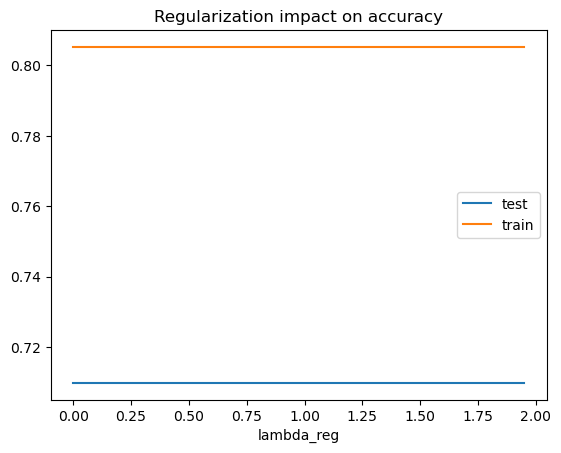

In [129]:
df.plot(x='lambda_reg', y=['test', 'train'], title='Regularization impact on accuracy')

In [130]:
y, y_hut = sp.symbols('y y_hut', real=True)
lambda_reg = sp.symbols('lambda_reg')
f = sp.Function('f')(y, y_hut, lambda_reg)

f = (y_hut-y)**2 + lambda_reg*abs(y_hut)

grad = sp.lambdify((y, y_hut, lambda_reg), f.diff(y_hut), 'numpy')
hess = sp.lambdify((y, y_hut, lambda_reg), f.diff(y_hut, y_hut), 'numpy')

y_rel = dtrain.get_label()

# grad, hess = grad(y=y_rel, y_hut=y_pred, lambda_reg=lambda_r), hess(y=y_rel, y_hut=y_pred, lambda_reg=lambda_r)

# if type(grad) in [float, int]:
#     grad = np.ones(y_pred.shape[0]) * grad
# if type(hess) in [float, int]:
#     hess = np.ones(y_pred.shape[0]) * hess
        
# grad, hess

# f.diff(y_hut)
y_pred = np.linspace(0, 1, 15)
y_rel = np.linspace(0, 10, 15)

y_pred = wT*xi
w = xiT-1*y_pred


y_pred - y_rel


    
    # params = {
    #     # 'objective': 'reg:squarederror',
    #     'tree_method': 'hist',
    #     'seed': 2001,
    # }

    # model = xgb.train(
    #     params=params,
    #     dtrain=dtrain,
    #     num_boost_round=100,
    #     obj=objective_function
    # )
    # return model

NameError: name 'wT' is not defined

In [107]:
y = dtrain.get_label()
X = dtrain.get_data()

w = np.matmul(y, np.linalg.pinv(dtrain.get_data().toarray()).T)

sum(w**2)

1.5160378499108447